In [1]:
import anndata
import numpy as np
import scipy as sp
import scvelo as scv
import scanpy as sc
import sys
import pandas as pd
import torch
import os
sys.path.insert(0, '../')
sys.path.insert(0, '../../velovae')
import topovelo as tpv
import velovae as vv
import matplotlib.pyplot as plt
from scipy.io import mmread, mmwrite
from numpy import savetxt
%load_ext autoreload
%autoreload 2

# E13.5

In [3]:
dataset = 'stereo-seq-gut-e13.5'
data_path_base = '/nfs/turbo/umms-welchjd/yichen/data/TopoVelo/stereo_seq/gut_e13.5'
rna_path = '/nfs/turbo/umms-welchjd/jialin/cytosignal_proj/stereo_seq/binned_intron_exon/stereo_seq_binned'
scratch_path = f"/scratch/welchjd_root/welchjd/shared_data/gyichen"
figure_path_base = f"{scratch_path}/figures/stereo-seq-gut-e13.5"
model_path_base = f"{scratch_path}/figures/stereo-seq-gut-e13.5"
#adata = anndata.read_h5ad(f'{rna_path}/E13.5/integrated/E13.5_gut.h5ad')
#adata = anndata.read_h5ad(f'{data_path_base}/adata_out.h5ad')

In [ ]:
X_spatial = adata.obsm['X_spatial']
plt.figure()
plt.scatter(X_spatial[:, 0], X_spatial[:, 1])
plt.show()

In [ ]:
cell_mask = (X_spatial[:, 0] > -75) & (X_spatial[:, 0] < 65) & (X_spatial[:, 1] < 75)
cell_mask = cell_mask & ~((X_spatial[:, 0] < -25) & (X_spatial[:, 1] < -10))
adata = adata[cell_mask]

In [ ]:
scv.pl.scatter(adata, basis='X_spatial', color=['Cdx2', 'Vil1', 'Vim', 'Pdgfra'], ncols=2)

In [ ]:
gidx = np.where(adata.var_names == "Cdx2")[0][0]
expr = adata.X[:, gidx].toarray().squeeze()
epi_mask = expr > 0
gidx = np.where(adata.var_names == "Vil1")[0][0]
expr = adata.X[:, gidx].toarray().squeeze()
epi_mask = epi_mask | (expr > 0)
cell_labels = np.array(['Mesenchymal' for i in range(adata.n_obs)])
cell_labels[epi_mask] = 'Epithelial'

In [ ]:
adata.obs['clusters'] = cell_labels

In [ ]:
scv.pl.scatter(adata, basis='spatial', save=f"{figure_path_base}/clusters.png")

In [ ]:
tpv.preprocess(adata,
               n_gene=2000,
               min_shared_counts=20,
               min_shared_cells=1,
               min_counts_s=10,
               min_counts_u=10,
               spatial_key='X_spatial')

In [ ]:
adata.write_h5ad(f"{data_path_base}/adata_pp.h5ad")

# VeloVAE

In [4]:
adata = anndata.read_h5ad(f"{data_path_base}/adata_pp.h5ad")
#adata = anndata.read_h5ad(f"{data_path_base}/adata_out.h5ad")

In [5]:
figure_path = f'{figure_path_base}/vv'
model_path = f'{model_path_base}/vv'

torch.manual_seed(2022)
np.random.seed(2022)

vae = vv.VAE(adata, 
             tmax=20, 
             dim_z=10, 
             device='cuda:0',
             reverse_gene_mode=False)
config = {
    
}
genes = ['Foxp2', 'Gnas', 'Npm1']
vae.train(adata,
          config=config,
          plot=False,
          gene_plot=genes,
          figure_path=figure_path,
          embed='spatial')
vae.save_model(model_path, 'encoder', 'decoder')
vae.save_anndata(adata,
                 'vv',
                 data_path_base,
                 file_name=None)

Estimating ODE parameters...


  0%|          | 0/2000 [00:00<?, ?it/s]

Detected 7 velocity genes.
Estimating the variance...


  0%|          | 0/2000 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/2000 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.44, 0.23977601642588048), (0.56, 0.7063458650426997)
(0.51, 0.7058535360338573), (0.49, 0.2171271105455921)
(0.47, 0.21842679954197006), (0.53, 0.7060769911892959)
KS-test result: [0. 0. 0.]
Initial induction: 1047, repression: 953/2000
Learning Rate based on Data Sparsity: 0.0002
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 14, test iteration: 26
*********       Stage 1: Early Stop Triggered at epoch 186.       *********
*********                

  0%|          | 0/2381 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.037
Average Set Size: 54
*********     Round 1: Early Stop Triggered at epoch 205.    *********
Change in noise variance: 0.2897
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 215.    *********
Change in noise variance: 0.0000
Change in x0: 0.5776
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 223.    *********
Change in noise variance: 0.0000
Change in x0: 0.5575
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 231.    *********
Change in noise variance: 0.0000
Change in x0: 0.5001
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 239.    *********
Change in noise variance: 0.0000
Change in x0: 0.4955
*********             Velocity Refinement Round 6    

In [6]:
figure_path = f'{figure_path_base}/vv'
model_path = f'{model_path_base}/vv'

torch.manual_seed(2022)
np.random.seed(2022)

vae = vv.VAE(adata, 
             tmax=20, 
             dim_z=10, 
             device='cuda:0',
             full_vb=True,
             reverse_gene_mode=False)
config = {
    
}
genes = ['Foxp2', 'Gnas', 'Npm1']
vae.train(adata,
          config=config,
          plot=False,
          gene_plot=genes,
          figure_path=figure_path,
          embed='spatial')
vae.save_model(model_path, 'encoder', 'decoder')
vae.save_anndata(adata, 'fullvb', data_path_base, file_name="adata_out.h5ad")

Estimating ODE parameters...


  0%|          | 0/2000 [00:00<?, ?it/s]

Detected 7 velocity genes.
Estimating the variance...


  0%|          | 0/2000 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/2000 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.44, 0.23977601642588048), (0.56, 0.7063458650426997)
(0.51, 0.7058535360338573), (0.49, 0.2171271105455921)
(0.47, 0.21842679954197006), (0.53, 0.7060769911892959)
KS-test result: [0. 0. 0.]
Initial induction: 1047, repression: 953/2000
Learning Rate based on Data Sparsity: 0.0002
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 14, test iteration: 26
*********       Stage 1: Early Stop Triggered at epoch 448.       *********
*********                

  0%|          | 0/2381 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.038
Average Set Size: 54
*********     Round 1: Early Stop Triggered at epoch 467.    *********
Change in noise variance: 0.2920
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 477.    *********
Change in noise variance: 0.0000
Change in x0: 0.6375
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 485.    *********
Change in noise variance: 0.0000
Change in x0: 0.4976
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 493.    *********
Change in noise variance: 0.0000
Change in x0: 0.4382
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 501.    *********
Change in noise variance: 0.0000
Change in x0: 0.3888
*********             Velocity Refinement Round 6    

# TopoVelo

In [7]:
from sklearn.neighbors import NearestNeighbors
X_pos = adata.obsm['X_spatial']
nn = NearestNeighbors(n_neighbors=16)
nn.fit(X_pos)
adata.obsp['spatial_graph'] = nn.kneighbors_graph()

In [8]:
figure_path = f'{figure_path_base}/tpv'
model_path = f'{model_path_base}/tpv'

vae = tpv.VAE(adata, 
              tmax=20, 
              dim_z=10, 
              device='cuda:0',
              graph_decoder=True,
              attention=False,
              reverse_gene_mode=False)
config = {
    #'learning_rate': 2e-4,
    #'learning_rate_ode': 5e-3,
    #'learning_rate_post': 2e-4
}
genes = ['Foxp2', 'Gnas', 'Npm1']
vae.train(adata,
          adata.obsp['spatial_graph'],
          "X_spatial",
          config=config,
          plot=False,
          gene_plot=genes,
          figure_path=figure_path,
          embed='spatial')
vae.save_model(model_path, 'encoder', 'decoder')
vae.save_anndata(adata, 'tpv', data_path_base, file_name="adata_out.h5ad")

Initialization using the steady-state and dynamical models.
Estimating ODE parameters...


  0%|          | 0/2000 [00:00<?, ?it/s]

Detected 7 velocity genes.
Estimating the variance...


  0%|          | 0/2000 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.56, 0.7075575233670713), (0.44, 0.24127304066365884)
(0.51, 0.7058437676760514), (0.49, 0.2170714845088359)
(0.47, 0.21918407163157463), (0.53, 0.7067842676044147)
KS-test result: [0. 0. 0.]
Initial induction: 1046, repression: 954/2000
Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/2000 [00:00<?, ?it/s]

Learning Rate based on Data Sparsity: 0.0002
--------------------------- Train a TopoVelo ---------------------------
*********               Creating a Graph Dataset              *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
*********       Stage 1: Early Stop Triggered at epoch 729.       *********
Summary: 
Train ELBO = 2917.762
Test ELBO = 3024.041
Total Time =   0 h :  4 m : 38 s

*********                      Stage  2                       *********
*********             Velocity Refinement Round 1              *********


  0%|          | 0/2381 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.043
Average Neighborhood Size: 147.8
Average Set Size: 14.4
Summary: 
Train ELBO = 5011.479
Test ELBO = 5062.282
Total Time =   0 h :  4 m : 49 s

*********       Round 1: Early Stop Triggered at epoch 754.       *********
Change in noise variance: 0.2901
*********             Velocity Refinement Round 2              *********
Summary: 
Train ELBO = 4980.561
Test ELBO = 5067.681
Total Time =   0 h :  4 m : 52 s

*********       Round 2: Early Stop Triggered at epoch 764.       *********
Change in noise variance: 0.0000
Change in x0: 0.8484
*********             Velocity Refinement Round 3              *********
Summary: 
Train ELBO = 5056.887
Test ELBO = 5069.560
Total Time =   0 h :  4 m : 55 s

*********       Round 3: Early Stop Triggered at epoch 772.       *********
Change in noise variance: 0.0000
Change in x0: 0.6946
*********             Velocity Refinement Round 4              *********
Summary: 
Train ELBO = 5007.087
Test ELBO = 5070.880
Total Ti

## Graph Attention

In [9]:
figure_path = f'{figure_path_base}/gat'
model_path = f'{model_path_base}/gat'

vae = tpv.VAE(adata, 
              tmax=20, 
              dim_z=10, 
              device='cuda:0',
              graph_decoder=True,
              attention=True,
              reverse_gene_mode=False)
config = {
    #'learning_rate': 2e-4,
    #'learning_rate_ode': 5e-3,
    #'learning_rate_post': 2e-4
}
genes = ['Foxp2', 'Gnas', 'Npm1']
vae.train(adata,
          adata.obsp['spatial_graph'],
          "X_spatial",
          config=config,
          plot=False,
          gene_plot=genes,
          figure_path=figure_path,
          embed='spatial')
vae.save_model(model_path, 'encoder', 'decoder')
vae.save_anndata(adata, 'gat', data_path_base, file_name="adata_out.h5ad")

Initialization using the steady-state and dynamical models.
Estimating ODE parameters...


  0%|          | 0/2000 [00:00<?, ?it/s]

Detected 7 velocity genes.
Estimating the variance...


  0%|          | 0/2000 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.56, 0.7075575233670713), (0.44, 0.24127304066365884)
(0.51, 0.7058437676760514), (0.49, 0.2170714845088359)
(0.47, 0.21918407163157463), (0.53, 0.7067842676044147)
KS-test result: [0. 0. 0.]
Initial induction: 1046, repression: 954/2000
Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/2000 [00:00<?, ?it/s]

Learning Rate based on Data Sparsity: 0.0002
--------------------------- Train a TopoVelo ---------------------------
*********               Creating a Graph Dataset              *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
*********       Stage 1: Early Stop Triggered at epoch 658.       *********
Summary: 
Train ELBO = 3117.566
Test ELBO = 3133.529
Total Time =   0 h : 12 m : 13 s

*********                      Stage  2                       *********
*********             Velocity Refinement Round 1              *********


  0%|          | 0/2381 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.030
Average Neighborhood Size: 147.8
Average Set Size: 17.7
Summary: 
Train ELBO = 5188.713
Test ELBO = 5179.393
Total Time =   0 h : 12 m : 34 s

*********       Round 1: Early Stop Triggered at epoch 668.       *********
Change in noise variance: 0.2933
*********             Velocity Refinement Round 2              *********
Summary: 
Train ELBO = 5237.580
Test ELBO = 5203.635
Total Time =   0 h : 12 m : 47 s

*********       Round 2: Early Stop Triggered at epoch 678.       *********
Change in noise variance: 0.0000
Change in x0: 0.2761
*********             Velocity Refinement Round 3              *********
Summary: 
Train ELBO = 5096.416
Test ELBO = 5195.513
Total Time =   0 h : 12 m : 57 s

*********       Round 3: Early Stop Triggered at epoch 686.       *********
Change in noise variance: 0.0000
Change in x0: 0.2203
*********             Velocity Refinement Round 4              *********
Summary: 
Train ELBO = 5236.966
Test ELBO = 5186.471
Total Ti

# scVelo

In [10]:
scv.tl.recover_dynamics(adata)
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)
scv.tl.latent_time(adata)

recovering dynamics (using 1/32 cores)


  0%|          | 0/119 [00:00<?, ?gene/s]

    finished (0:00:29) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/32 cores)


  0%|          | 0/2381 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 3 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


In [11]:
adata.write_h5ad(f"{data_path_base}/adata_out.h5ad")

# Informative Time Prior

In [12]:
tpv.model.model_util.get_spatial_tprior(adata, 20, q=0.95)

saving figure to file /scratch/welchjd_root/welchjd/shared_data/gyichen/figures/stereo-seq-gut-e13.5/gut_tprior.png


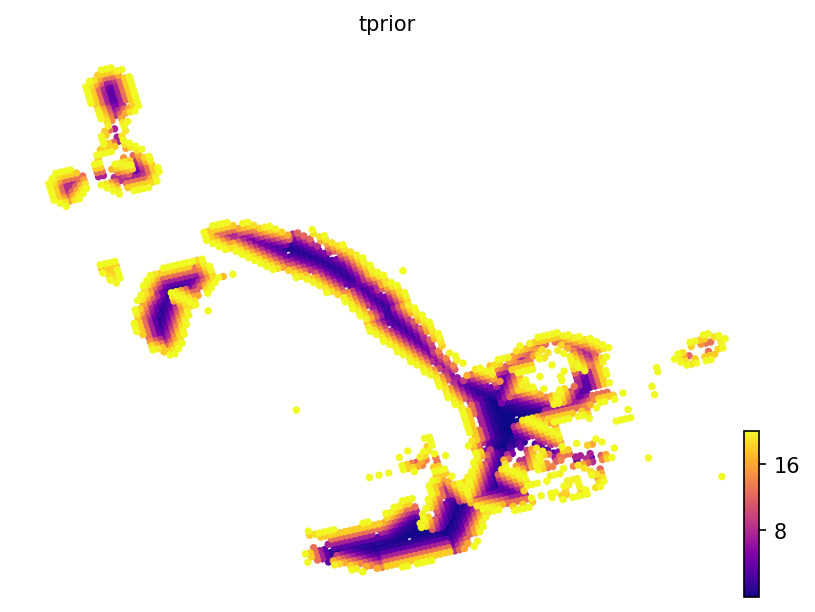

In [9]:
scv.pl.scatter(adata, basis='spatial', color='tprior', color_map='plasma', dpi=150,
               save=f"{figure_path_base}/gut_tprior.png")

In [13]:
figure_path = f'{figure_path_base}/tpv_tprior'
model_path = f'{model_path_base}/tpv_tprior'

vae = tpv.VAE(adata, 
              tmax=20, 
              dim_z=10, 
              device='cuda:0',
              tprior='tprior',
              graph_decoder=True,
              attention=True,
              reverse_gene_mode=False)
config = {
    'kl_t': 1e-8
}
genes = ['Foxp2', 'Gnas', 'Npm1']
vae.train(adata,
          adata.obsp['spatial_graph'],
          "X_spatial",
          config=config,
          plot=False,
          gene_plot=genes,
          figure_path=figure_path,
          embed='spatial')
vae.save_model(model_path, 'encoder', 'decoder')
vae.save_anndata(adata, 'gat_tprior', data_path_base, file_name="adata_out.h5ad")

Initialization using the steady-state and dynamical models.
Estimating ODE parameters...


  0%|          | 0/2000 [00:00<?, ?it/s]

Detected 7 velocity genes.
Estimating the variance...


  0%|          | 0/2000 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.56, 0.7075575233670713), (0.44, 0.24127304066365884)
(0.51, 0.7058437676760514), (0.49, 0.2170714845088359)
(0.47, 0.21918407163157463), (0.53, 0.7067842676044147)
KS-test result: [0. 0. 0.]
Initial induction: 1046, repression: 954/2000
Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/2000 [00:00<?, ?it/s]

Using informative time prior.
Learning Rate based on Data Sparsity: 0.0002
--------------------------- Train a TopoVelo ---------------------------
*********               Creating a Graph Dataset              *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
*********       Stage 1: Early Stop Triggered at epoch 257.       *********
Summary: 
Train ELBO = -1025810219874081832960.000
Test ELBO = -3816226193769028911104.000
Total Time =   0 h :  4 m :  1 s

*********                      Stage  2                       *********
*********             Velocity Refinement Round 1              *********


  0%|          | 0/2381 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.058
Average Neighborhood Size: 147.8
Average Set Size: 13.9
Summary: 
Train ELBO = -914710850297734889472.000
Test ELBO = -3816226193769028911104.000
Total Time =   0 h :  4 m : 22 s

*********       Round 1: Early Stop Triggered at epoch 265.       *********
Change in noise variance: 0.2412
*********             Velocity Refinement Round 2              *********
Summary: 
Train ELBO = -827160169854210670592.000
Test ELBO = -3816226193769028911104.000
Total Time =   0 h :  4 m : 32 s

*********       Round 2: Early Stop Triggered at epoch 273.       *********
Change in noise variance: 0.0008
Change in x0: 0.7403
*********             Velocity Refinement Round 3              *********
Summary: 
Train ELBO = -1343954067700741832704.000
Test ELBO = -3816226193769028911104.000
Total Time =   0 h :  4 m : 43 s

*********       Round 3: Early Stop Triggered at epoch 281.       *********
Change in noise variance: 0.0000
Change in x0: 0.8050
*********             

Computing velocity embedding using scVelo
computing velocity graph (using 1/32 cores)


  0%|          | 0/2381 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_spatial', embedded velocity vectors (adata.obsm)
computing velocity graph (using 1/32 cores)


  0%|          | 0/2381 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_spatial', embedded velocity vectors (adata.obsm)
Computing velocity embedding using scVelo
computing velocity graph (using 1/32 cores)


  0%|          | 0/2381 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'vv_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vv_velocity_spatial', embedded velocity vectors (adata.obsm)
computing velocity graph (using 1/32 cores)


  0%|          | 0/2381 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'vv_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vv_velocity_spatial', embedded velocity vectors (adata.obsm)
Computing velocity embedding using scVelo
computing velocity graph (using 1/32 cores)


  0%|          | 0/2381 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'fullvb_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'fullvb_velocity_spatial', embedded velocity vectors (adata.obsm)
computing velocity graph (using 1/32 cores)


  0%|          | 0/2381 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'fullvb_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'fullvb_velocity_spatial', embedded velocity vectors (adata.obsm)
Computing velocity embedding using scVelo
computing velocity graph (using 1/32 cores)


  0%|          | 0/2381 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'tpv_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'tpv_velocity_spatial', embedded velocity vectors (adata.obsm)
computing velocity graph (using 1/32 cores)


  0%|          | 0/2381 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'tpv_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'tpv_velocity_spatial', embedded velocity vectors (adata.obsm)
Computing velocity embedding using scVelo
computing velocity graph (using 1/32 cores)


  0%|          | 0/2381 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'gat_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'gat_velocity_spatial', embedded velocity vectors (adata.obsm)
computing velocity graph (using 1/32 cores)


  0%|          | 0/2381 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'gat_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'gat_velocity_spatial', embedded velocity vectors (adata.obsm)
---     Computing Peformance Metrics     ---
Dataset Size: 2381 cells, 2000 genes
---   Plotting  Results   ---
computing velocity graph (using 1/32 cores)


  0%|          | 0/2381 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_spatial', embedded velocity vectors (adata.obsm)
saving figure to file /scratch/welchjd_root/welchjd/shared_data/gyichen/figures/stereo-seq-gut-e13.5/gut_fit_stream.png


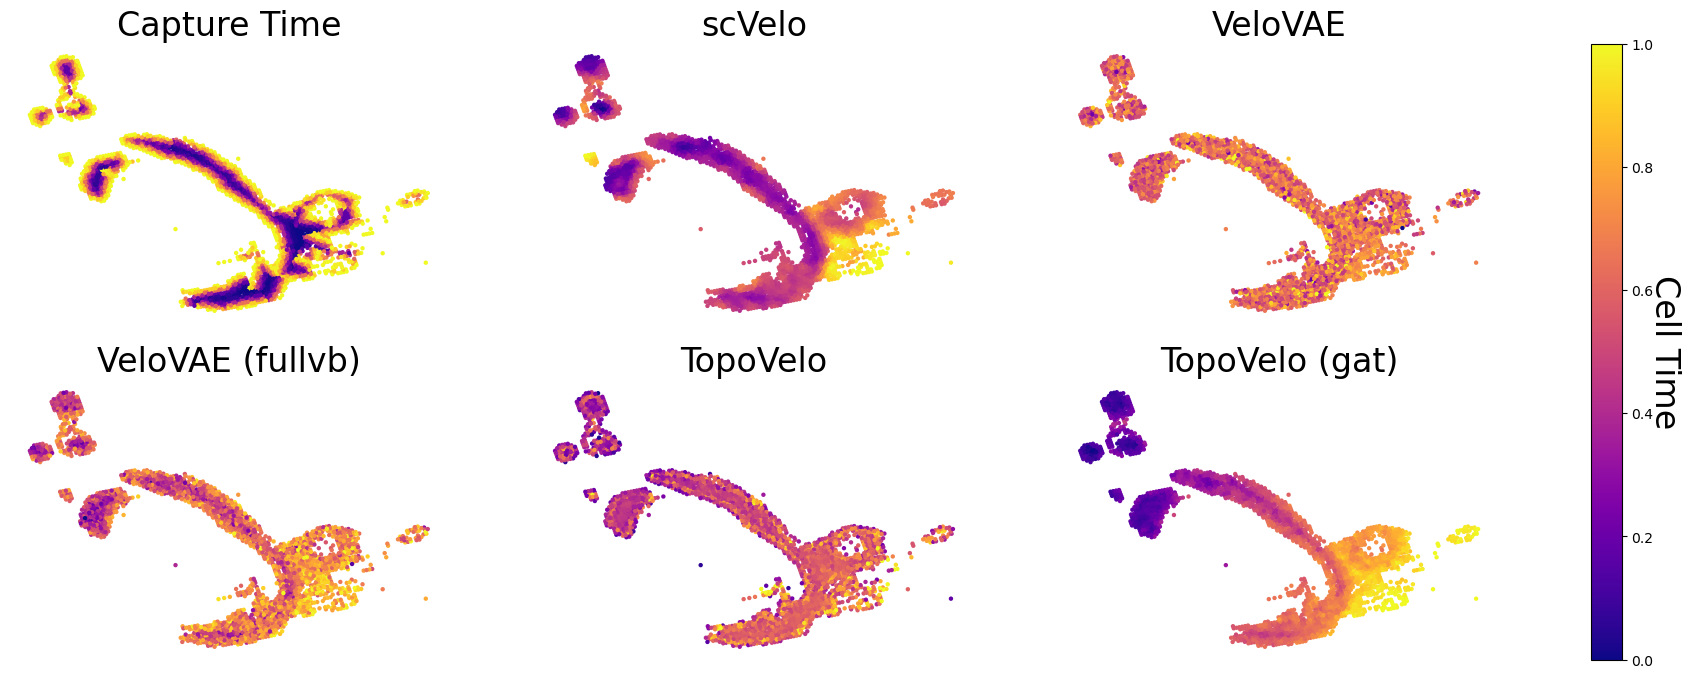

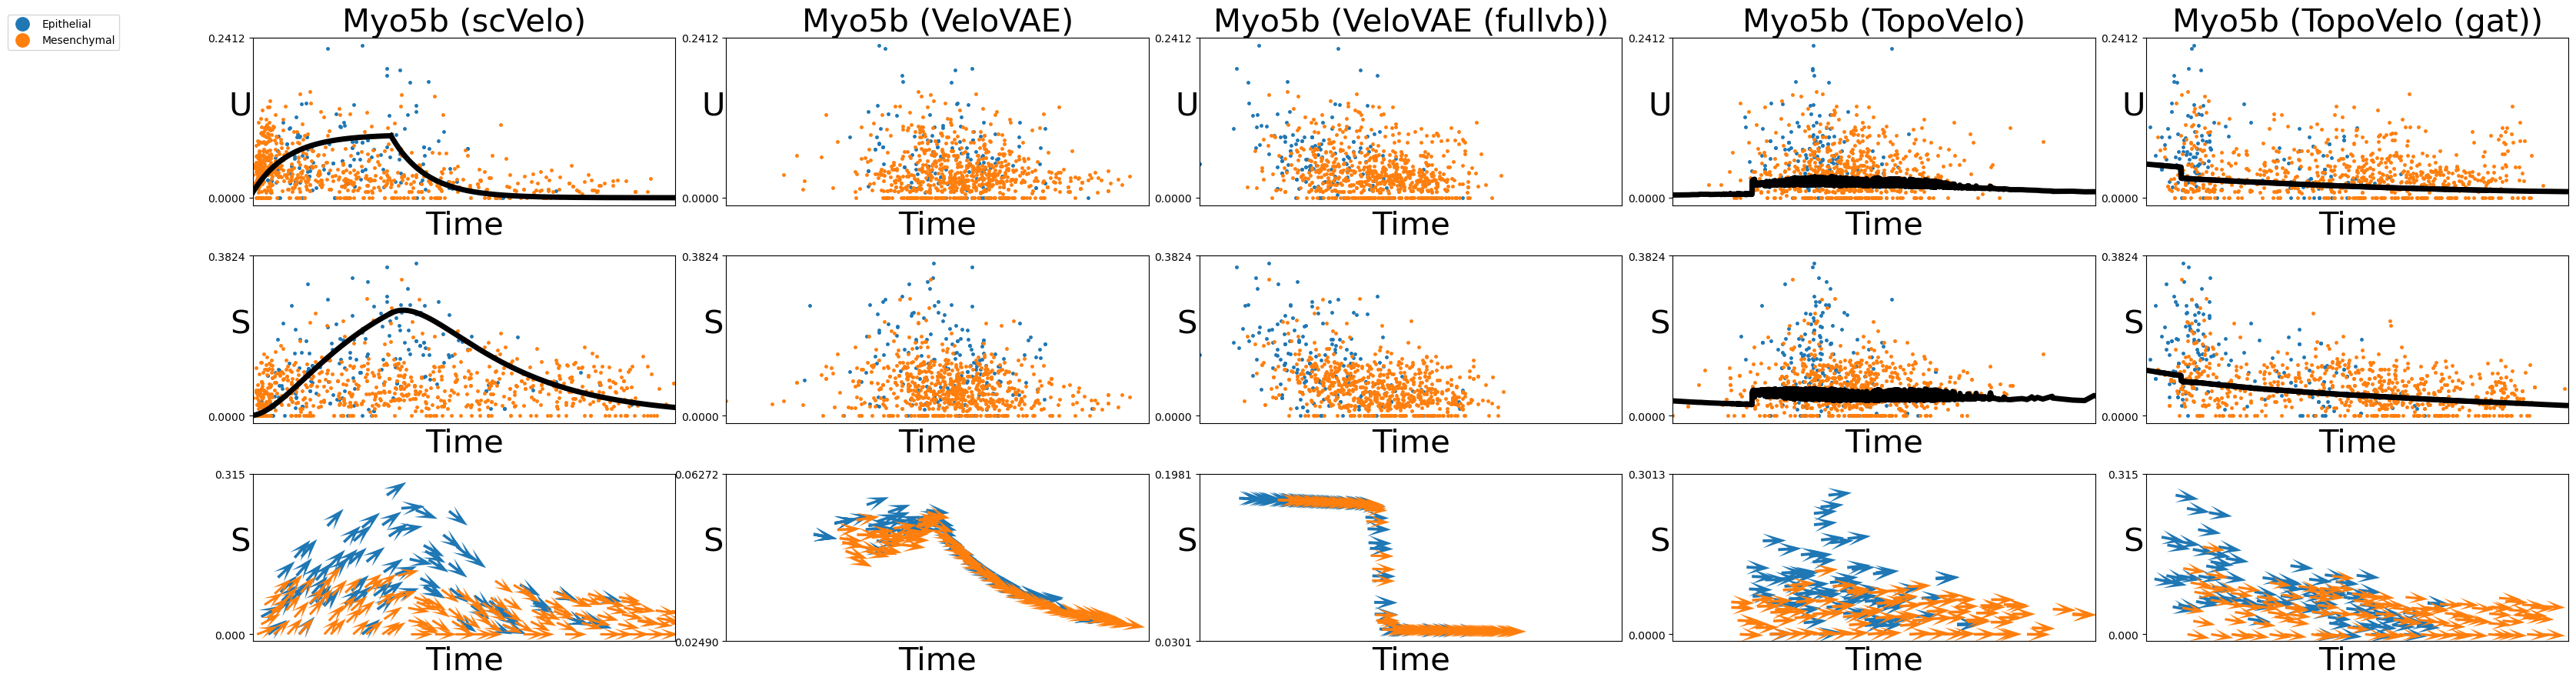

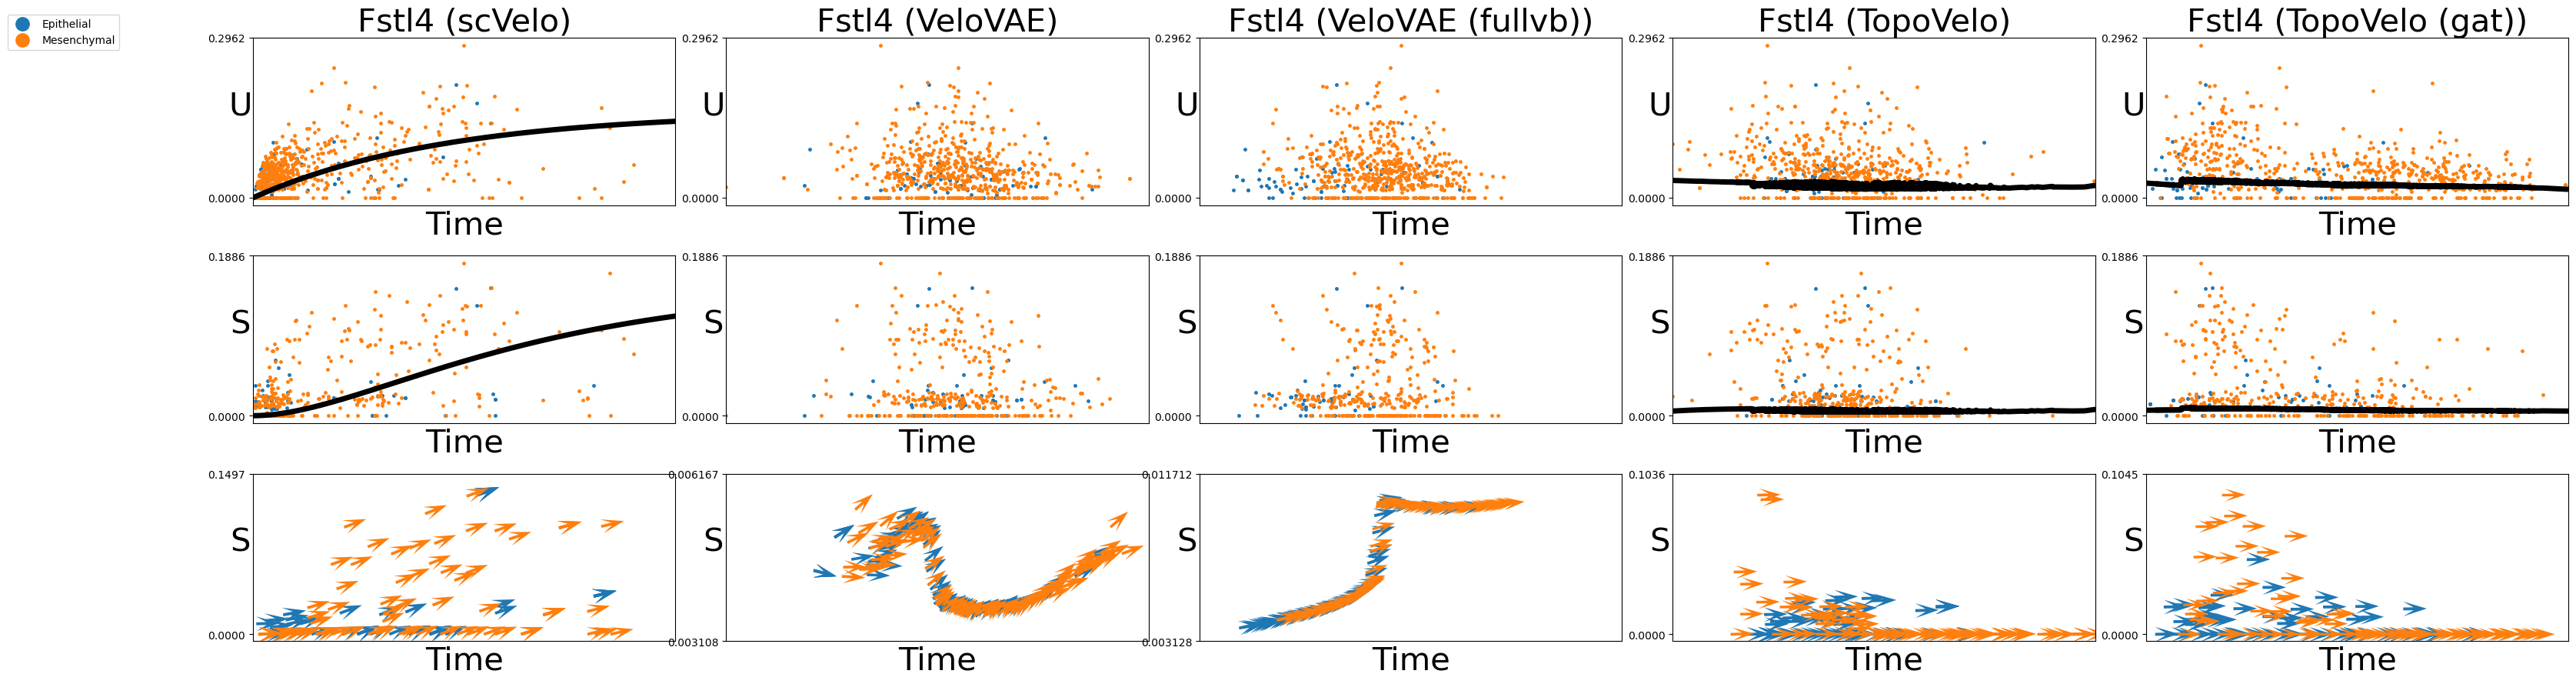

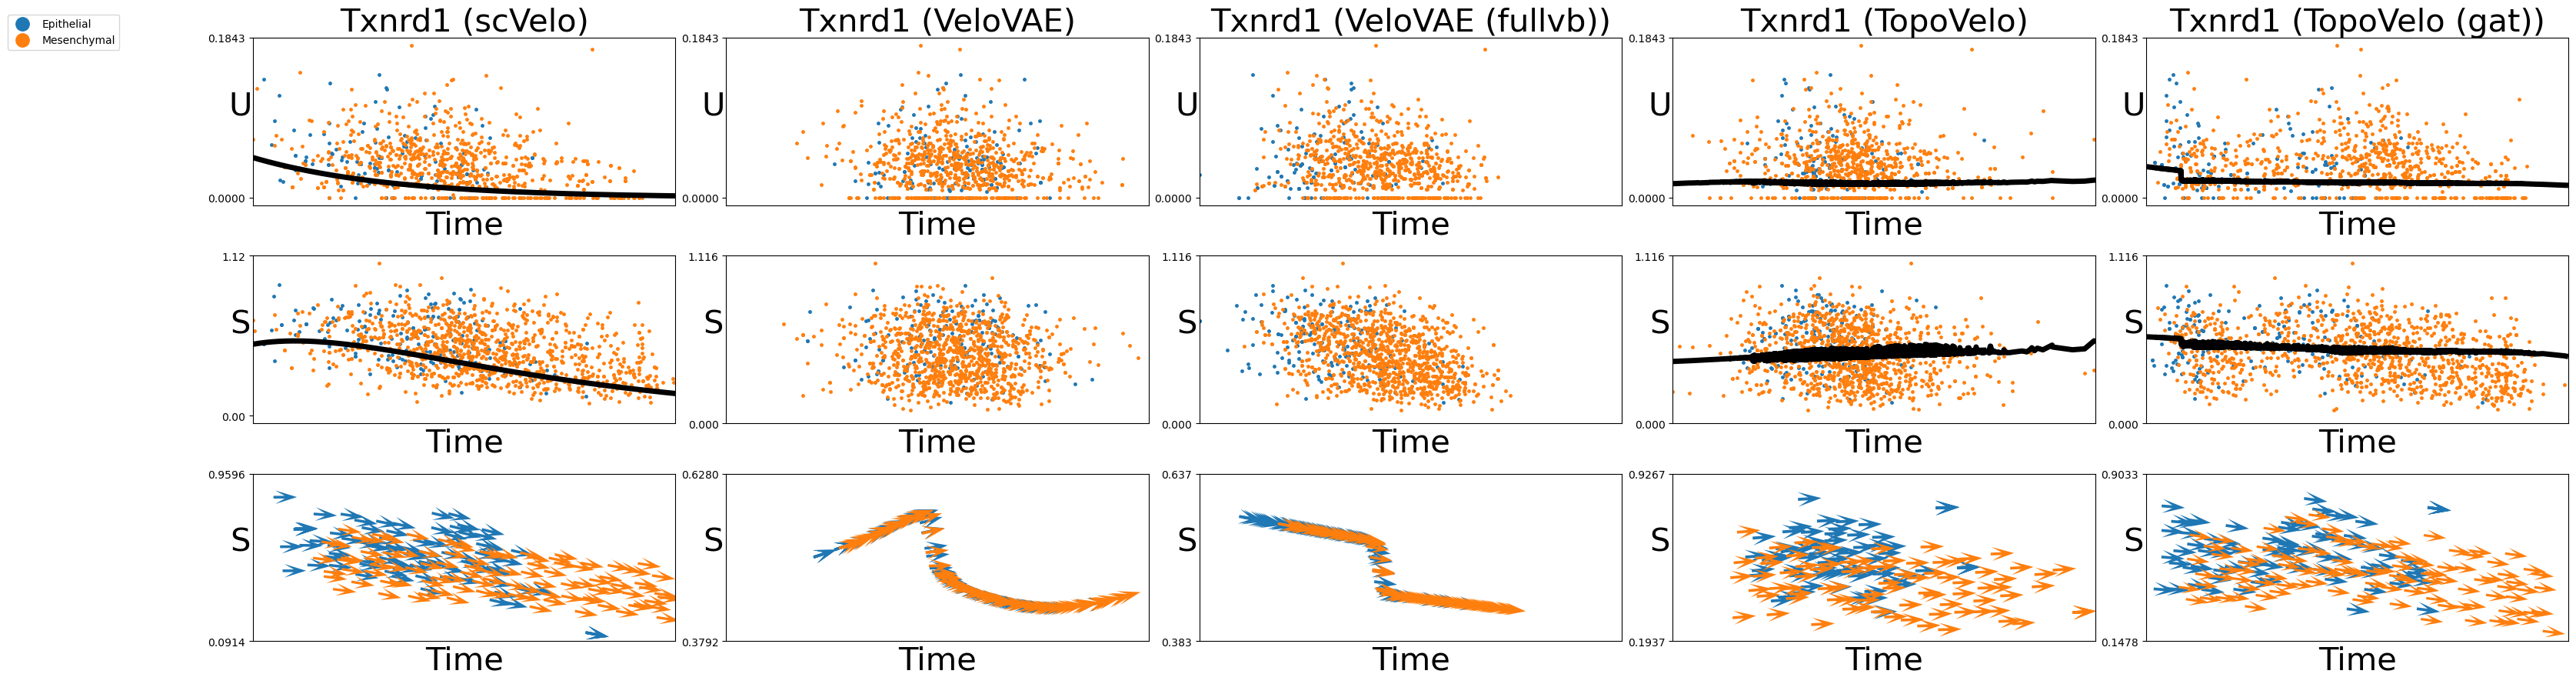

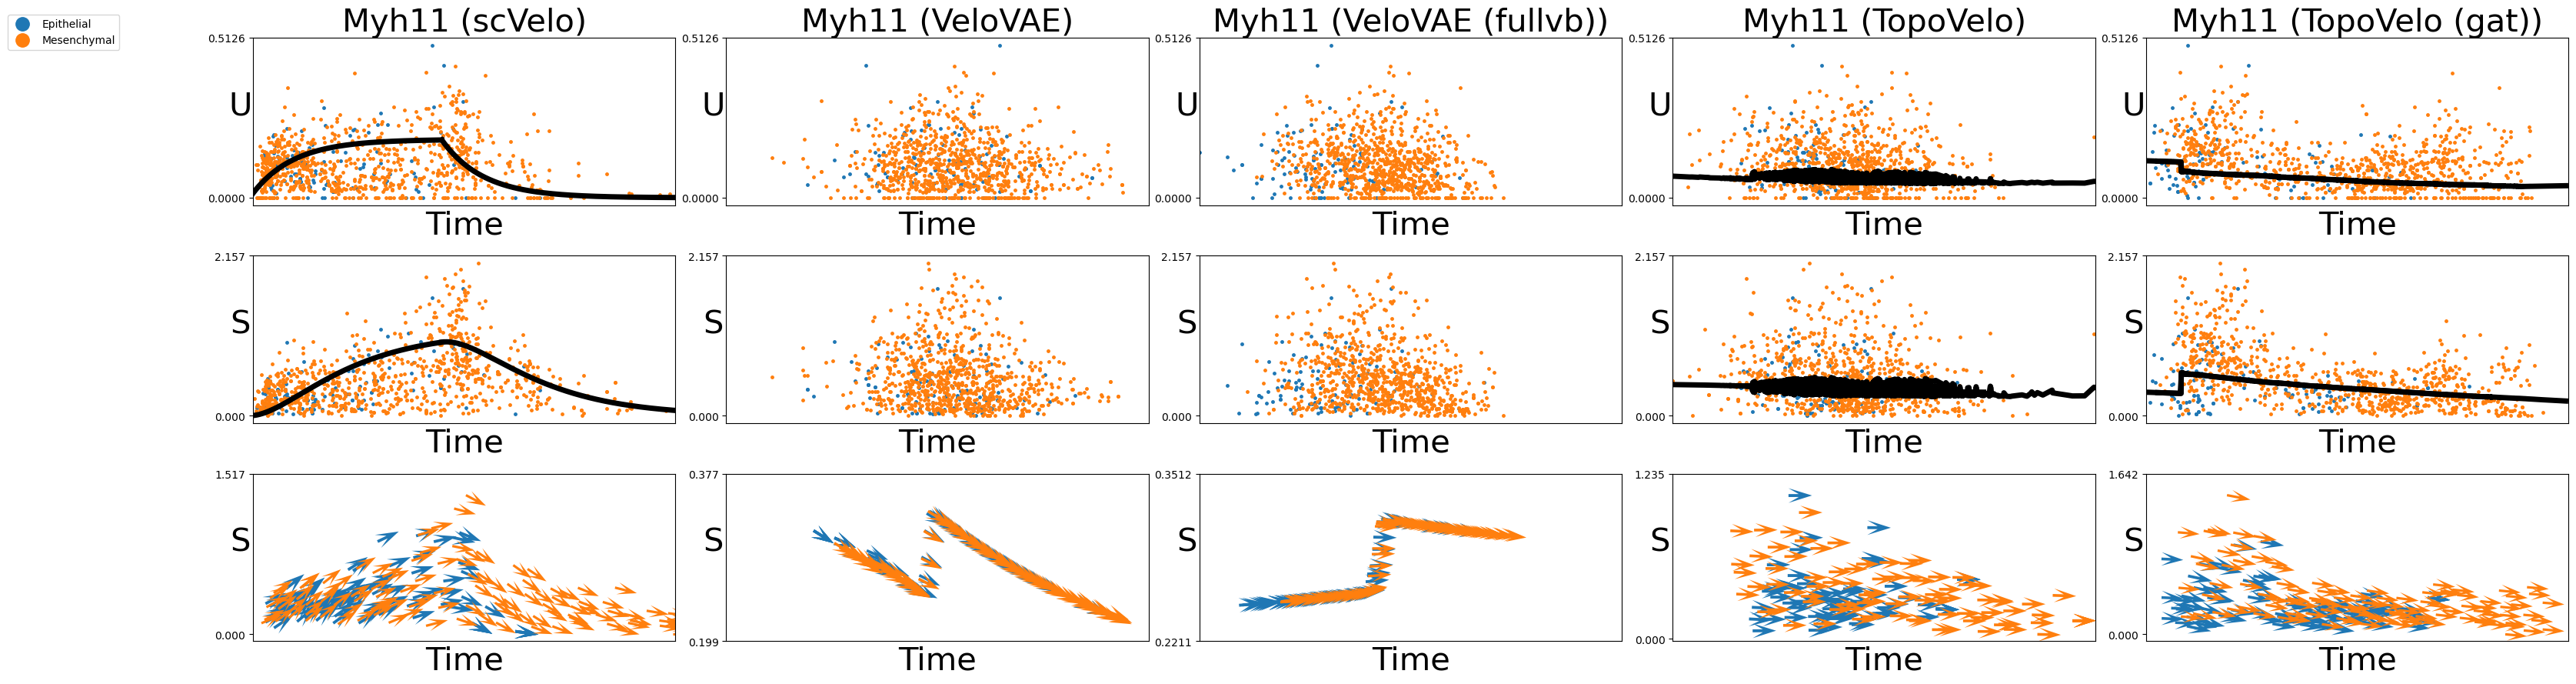

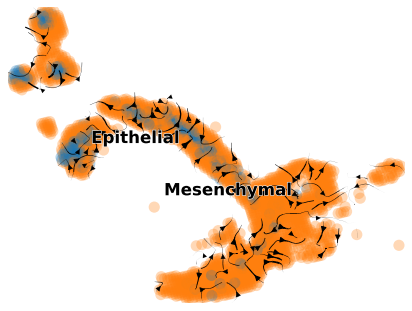

computing velocity graph (using 1/32 cores)


  0%|          | 0/2381 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'vv_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vv_velocity_spatial', embedded velocity vectors (adata.obsm)
saving figure to file /scratch/welchjd_root/welchjd/shared_data/gyichen/figures/stereo-seq-gut-e13.5/gut_vv_stream.png


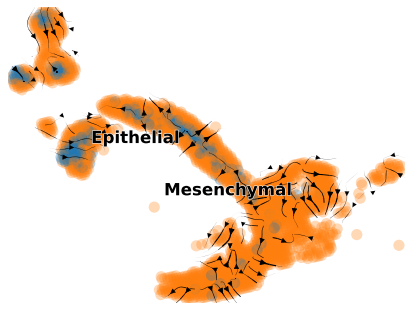

computing velocity graph (using 1/32 cores)


  0%|          | 0/2381 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'fullvb_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'fullvb_velocity_spatial', embedded velocity vectors (adata.obsm)
saving figure to file /scratch/welchjd_root/welchjd/shared_data/gyichen/figures/stereo-seq-gut-e13.5/gut_fullvb_stream.png


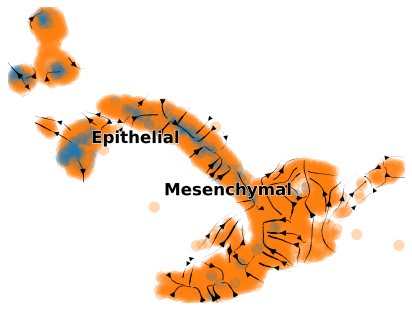

computing velocity graph (using 1/32 cores)


  0%|          | 0/2381 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'tpv_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'tpv_velocity_spatial', embedded velocity vectors (adata.obsm)
saving figure to file /scratch/welchjd_root/welchjd/shared_data/gyichen/figures/stereo-seq-gut-e13.5/gut_tpv_stream.png


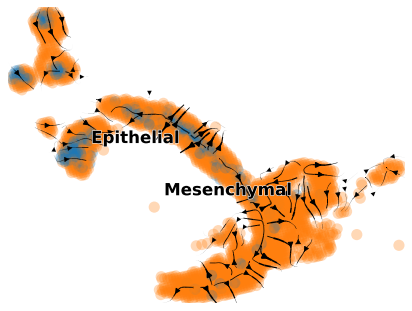

saving figure to file /scratch/welchjd_root/welchjd/shared_data/gyichen/figures/stereo-seq-gut-e13.5/gut_tpv_true_velocity.png


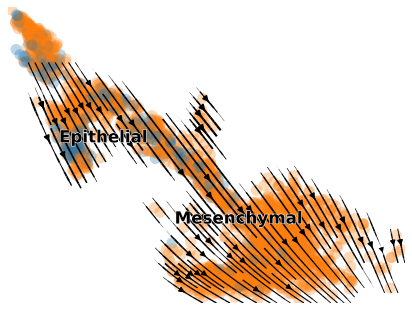

computing velocity graph (using 1/32 cores)


  0%|          | 0/2381 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'gat_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'gat_velocity_spatial', embedded velocity vectors (adata.obsm)
saving figure to file /scratch/welchjd_root/welchjd/shared_data/gyichen/figures/stereo-seq-gut-e13.5/gut_gat_stream.png


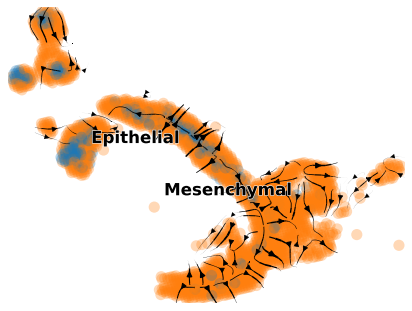

saving figure to file /scratch/welchjd_root/welchjd/shared_data/gyichen/figures/stereo-seq-gut-e13.5/gut_gat_true_velocity.png


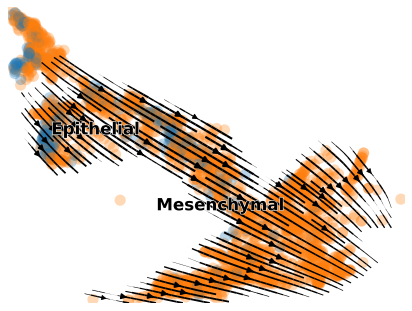

In [18]:
tpv.plotting.set_dpi(100)
genes = np.random.choice(adata.var_names[adata.var['velocity_genes'].to_numpy()], 4)
res, res_type = tpv.post_analysis(adata,
                                  'gut',
                                  ['scVelo', 'VeloVAE', 'VeloVAE', 'TopoVelo', 'TopoVelo'],
                                  ['fit', 'vv', 'fullvb', 'tpv', 'gat'],
                                  spatial_graph_key='spatial_graph',
                                  spatial_key='X_spatial',
                                  compute_metrics=True,
                                  spatial_velocity_graph=True,
                                  genes=genes,
                                  embed='spatial',
                                  plot_type=['time', 'stream', 'gene'],
                                  figure_path=figure_path_base)

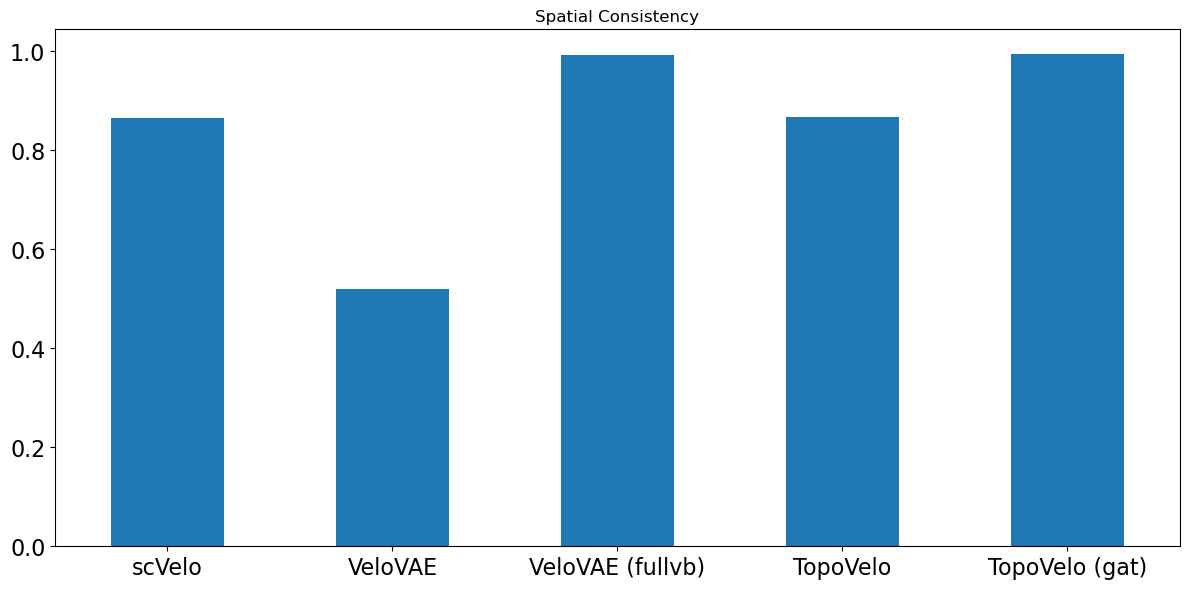

In [39]:
fig, ax = plt.subplots(figsize=(12, 6))
res.loc['Spatial Consistency', :].plot.bar(ax=ax, subplots=True, fontsize=16, rot=0)
plt.tight_layout()
fig.savefig(f"{figure_path_base}/perf.png")

In [40]:
res

,scVelo,VeloVAE,VeloVAE (fullvb),TopoVelo,TopoVelo (gat)
MSE Train,0.097,0.046,0.047,0.042,0.042
MSE Test,NaN,0.046,0.050,0.041,0.040
MAE Train,0.218,0.166,0.173,0.162,0.162
MAE Test,NaN,0.166,0.178,0.159,0.159
LL Train,-221.115,260.930,239.769,265.591,266.512
LL Test,NaN,263.463,233.824,268.725,270.284
Training Time,NaN,NaN,NaN,NaN,NaN
corr,0.314,0.006,0.216,-0.097,0.065
"CBDir (Embed, Velocity Genes)",NaN,NaN,NaN,NaN,NaN
CBDir (Velocity Genes),NaN,NaN,NaN,NaN,NaN
